# IKr fitting GA
**Written by Akwasi Darkwah Akwaboah**<br>
**01/20/2020**

**Clamping Protocol**

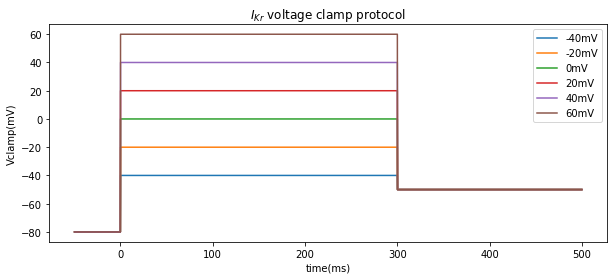

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Vcm = np.arange(-40, 61, 20) 
Vhold = -50  #mV
dt = 0.1  # time step
Vh_pre = -80    # mV,prepulse Holding Voltage
Vh_post = -50   # mV post holding
tStart = -50
tEnd = 500.0
nStep = np.int(np.ceil((tEnd - tStart) / dt))  # number of steps
Vm = np.zeros((nStep + 1, 1), dtype=np.float)
plot_time = np.empty((nStep, 1), dtype=np.float)
plot_Vm = np.empty((nStep, len(Vcm)), dtype=np.float)
t = np.linspace(tStart, tEnd, nStep + 1)
i = 0  #column selector

for Vc in Vcm:
    tNow = tStart
    Vm[0] = Vh_pre
    for iStep in np.arange(nStep):
            Vm[iStep+1] = (tNow < 0.0)*Vh_pre + (0.0 <= tNow < 300.0) * Vc +  (tNow >= 300.0) * Vh_post
            plot_Vm[iStep, i] = Vm[iStep]
            plot_time[iStep] = tNow
            tNow = tStart + iStep * dt
    i = i + 1 #increment to next clamp column

plt.figure(figsize = (10,4))
plt.plot(plot_time[5:], plot_Vm[5:])
plt.xlabel('time(ms)')
plt.ylabel('Vclamp(mV)')
plt.title('$I_{Kr}$ voltage clamp protocol')
plt.legend(['-40mV', '-20mV', '0mV', '20mV', '40mV', '60mV'], loc='best')

#plt.grid()
plt.show()

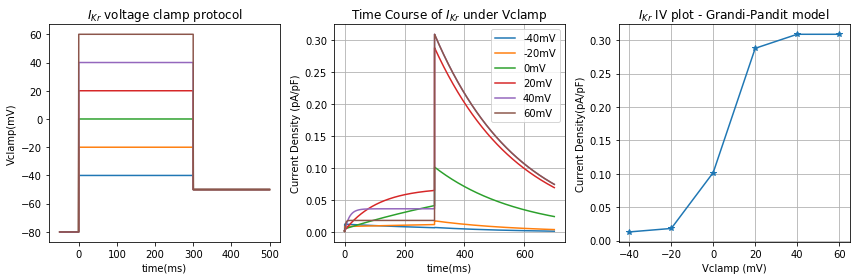

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def Ikr_func(K_gkr, a_xrss, b_xrss, a_txr, b_txr, c_txr, d_txr, e_txr, f_txr, g_txr, h_txr, j_txr, a_rkr, b_rkr):

    Vcm = np.arange(-40, 61, 20)    # mV, Command Voltage
    Vh_pre = -80    # mV,prepulse Holding Voltage
    Vh_post = -50   # mV post holding
    Ko = 5.4 #mM
    dt = 0.1  # time step
    tStart = -0.5000
    tEnd = 700.0
    nStep = np.int(np.ceil((tEnd - tStart) / dt))  # number of steps
    # Store the state variables

    gKr = K_gkr * np.sqrt(Ko/ 5.4)

    Vm = np.zeros((nStep + 1, 1), dtype=np.float)
    plot_xkr = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_rkr = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_tauxr = np.zeros((nStep, len(Vcm)), dtype=np.float)

    plot_IKr = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_time = np.empty((nStep, 1), dtype=np.float)
    plot_Im = np.empty((nStep, len(Vcm)), dtype=np.float)

    t = np.linspace(tStart, tEnd, nStep + 1)
    i = 0  #column selector

    for Vc in Vcm:
        tNow = tStart
        Vm[0] = Vh_pre
        xkr = 0.044245060085  # initial condition
        EK = -82.8  # mV, Potassium Nernst potential
        Cmem = 1.38e-10  # todo: Cmem value in appropriate orders
        for iStep in np.arange(nStep):
            Vm[iStep+1] = (tNow < 0.0)*Vh_pre + (0.0 <= tNow < 300.0) * Vc +  (tNow >= 300.0) * Vh_post
            xr_ss = 1 / (1 + np.exp(-(Vm[iStep] + a_xrss) / b_xrss))
            tau_xr = (a_txr/(1+np.exp(-(Vm[iStep]+b_txr)/c_txr)))*(d_txr/(1+np.exp((Vm[iStep]+e_txr)/f_txr))) + (g_txr/(1+np.exp((Vm[iStep]+h_txr)/j_txr)))
            dxkr = ((xr_ss - xkr)/ tau_xr)*dt
            r_kr = 1/(1+np.exp((Vm[iStep]+a_rkr)/b_rkr))
            IKr = gKr * xkr * r_kr * (Vm[iStep] - EK)
            Im = IKr + Cmem*((Vm[iStep+1] - Vm[iStep]) / (t[iStep+1] - t[iStep]))

            plot_xkr[iStep, i] = xkr
            plot_rkr[iStep, i] = r_kr
            plot_tauxr[iStep, i] = tau_xr
            plot_IKr[iStep, i] = IKr
            plot_Im[iStep, i] = Im
            plot_time[iStep] = tNow
            xkr = xkr+dxkr
            tNow = tStart + iStep * dt
        i = i + 1
    Ikr_peaks = np.max(plot_IKr, axis=0)
    return Ikr_peaks, plot_time, plot_IKr

plt.figure(figsize = (12,4))
plt.subplot(1,3,1)
plt.plot(plot_time[5:], plot_Vm[5:])
plt.xlabel('time(ms)')
plt.ylabel('Vclamp(mV)')
plt.title('$I_{Kr}$ voltage clamp protocol')
#plt.legend(['-40mV', '-20mV', '0mV', '20mV', '40mV', '60mV'], loc='best')


Ikr_tails, time, plt_IKr = Ikr_func(0.035, 10, 5, 550, 22, 9, 6, 11, 9, 230, 40, 20, 74, 24)
Vcm = np.arange(-40, 61, 20)
plt.subplot(1, 3,3)
plt.plot(Vcm, Ikr_tails, '-*')
plt.xlabel('Vclamp (mV)')
plt.ylabel('Current Density(pA/pF)')
plt.title('$I_{Kr}$ IV plot - Grandi-Pandit model')
plt.grid()
#plt.show()

plt.subplot(1,3,2)
plt.plot(time, plt_IKr)
plt.xlabel('time(ms)')
plt.ylabel('Current Density (pA/pF)')
plt.title('Time Course of $I_{Kr}$ under Vclamp')
plt.legend(['-40mV', '-20mV', '0mV', '20mV', '40mV', '60mV'], loc='best')
plt.grid()
plt.tight_layout()
plt.show()

***IKr function for GA, reduced computational time***

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def Ikr_func(K_gkr, a_xrss, b_xrss, a_txr, b_txr, c_txr, d_txr, e_txr, f_txr, g_txr, h_txr, j_txr, a_rkr, b_rkr):

    Vcm = np.arange(-40, 61, 20)    # mV, Command Voltage
    Vh_pre = -80    # mV,prepulse Holding Voltage
    Vh_post = -50   # mV post holding
    Ko = 5.4 #mM
    dt = 0.1  # time step
    tStart = -0.5000
    tEnd = 500.0
    nStep = np.int(np.ceil((tEnd - tStart) / dt))  # number of steps
    # Store the state variables

    gKr = K_gkr * np.sqrt(Ko/ 5.4)

    Vm = np.zeros((nStep + 1, 1), dtype=np.float)
    plot_xkr = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_rkr = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_tauxr = np.zeros((nStep, len(Vcm)), dtype=np.float)

    plot_IKr = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_time = np.empty((nStep, 1), dtype=np.float)
    plot_Im = np.empty((nStep, len(Vcm)), dtype=np.float)

    t = np.linspace(tStart, tEnd, nStep + 1)
    i = 0  #column selector

    for Vc in Vcm:
        tNow = tStart
        Vm[0] = Vh_pre
        xkr = 0.044245060085  # initial condition
        EK = -82.8  # mV, Potassium Nernst potential
        Cmem = 1.38e-10  # todo: Cmem value in appropriate orders
        for iStep in np.arange(nStep):
            Vm[iStep+1] = (tNow < 0.0)*Vh_pre + (0.0 <= tNow < 300.0) * Vc +  (tNow >= 300.0) * Vh_post
            xr_ss = 1 / (1 + np.exp((-Vm[iStep] + a_xrss) / b_xrss))
            tau_xr = (a_txr/(1+np.exp(-(Vm[iStep]+b_txr)/c_txr)))*(d_txr/(1+np.exp((Vm[iStep]+e_txr)/f_txr))) + (g_txr/(1+np.exp((Vm[iStep]+h_txr)/j_txr)))
            dxkr = ((xr_ss - xkr)/ tau_xr)*dt
            r_kr = 1/(1+np.exp((Vm[iStep]+a_rkr)/b_rkr))
            IKr = gKr * xkr * r_kr * (Vm[iStep] - EK)
            Im = IKr + Cmem*((Vm[iStep+1] - Vm[iStep]) / (t[iStep+1] - t[iStep]))

            plot_xkr[iStep, i] = xkr
            plot_rkr[iStep, i] = r_kr
            plot_tauxr[iStep, i] = tau_xr
            plot_IKr[iStep, i] = IKr
            plot_Im[iStep, i] = Im
            plot_time[iStep] = tNow
            xkr = xkr+dxkr
            tNow = tStart + iStep * dt
        i = i + 1
    Ikr_peaks = np.max(plot_IKr, axis=0)
    return Ikr_peaks, plot_time, plot_IKr

In [4]:
# Creating a class to hold the trials data
import pickle

class GA_trial:
    gen_num = 0
    loss = 0
    R_sq_ini = 0
    R_sq_fin = 0
    Parameters = 0
    final_fit_Val = 0
    time = 0
    cur_time_fit = 0
    cur_time_ini = 0
    Vcm = 0
    I_peaks_fin = 0
    I_peaks_ini = 0
    
trial1 = GA_trial()
trial1.loss = np.arange(1,10,2)
trial1.fitness = 3
print(trial1.loss)

pickle.dump(trial1, open('trial_save.p', 'wb'))
C = pickle.load(open('trial_save.p', 'rb'))
print(C.loss)

[1 3 5 7 9]
[1 3 5 7 9]


**GA 1**

generation:  0
Runtime:  3.1148809483333326 mins
fitness:  0.39650391651896927
generation:  5
Runtime:  18.586882260000007 mins
fitness:  0.1693168516644694
generation:  10
Runtime:  34.199569903333334 mins
fitness:  0.07734616314328782
generation:  15
Runtime:  49.85548824499998 mins
fitness:  0.06052456461891794
generation:  20
Runtime:  65.47660147166665 mins
fitness:  0.05445408562476895
generation:  25
Runtime:  81.03220095666666 mins
fitness:  0.04834845875769837
generation:  30
Runtime:  96.56541050166668 mins
fitness:  0.03914918982553829
generation:  35
Runtime:  112.34154281166666 mins
fitness:  0.02351607078151469
generation:  40
Runtime:  128.16015293666666 mins
fitness:  0.005459378408451134
generation:  45
Runtime:  143.9725806416667 mins
fitness:  0.00511153761386349
generation:  50
Runtime:  159.52282611833334 mins
fitness:  0.004911414099935796
generation:  55
Runtime:  174.98946467166664 mins
fitness:  0.004835822696866881
generation:  60
Runtime:  190.42807679 mins
f

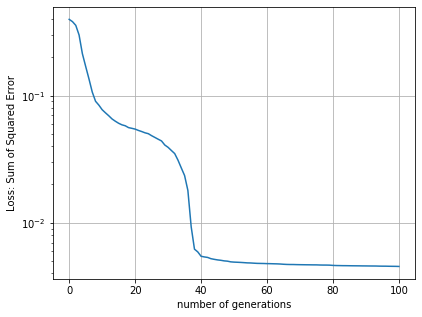

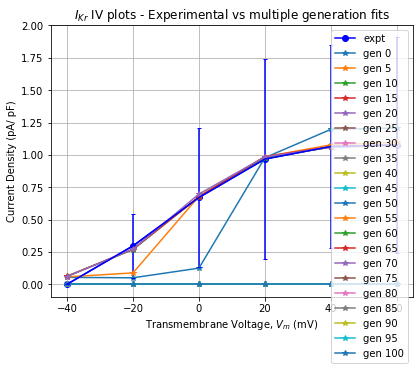

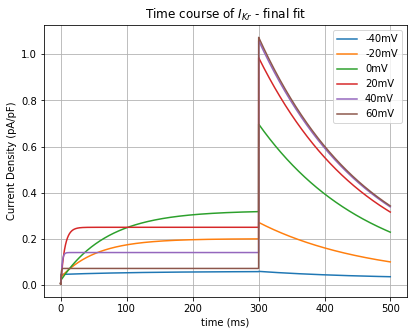

In [14]:
import timeit
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')


timer_start = timeit.default_timer()
# inputs, x
V = np.arange(-40, 61, 20)    # mV, Command Voltage

# actual Y
Ikr_act = np.array(
    [0.0000, 0.296491453, 0.670409, 0.967468331, 1.064629846, 1.076653804 ])
Ikr_err = np.array([0.000, 0.246868565, 0.539902624, 0.771099748, 0.782198549, 0.832950241])

# Population
# Parameter initialization
C = np.empty((140, 14))
C[:, 0] = np.random.uniform(0, 0.1, C.shape[0])     #g
C[:, 1] = np.random.uniform(5, 15, C.shape[0]) #ax
C[:, 2] = np.random.uniform(3, 8, C.shape[0])     #bx
C[:, 3] = np.random.uniform(500, 600, C.shape[0])     #ex
C[:, 4] = np.random.uniform(15, 27, C.shape[0])       #ta
C[:, 5] = np.random.uniform(7, 12, C.shape[0])         #td
C[:, 6] = np.random.uniform(4, 9, C.shape[0])      #te
C[:, 7] = np.random.uniform(8, 15, C.shape[0])         #tf
C[:, 8] = np.random.uniform(7, 12, C.shape[0])      #ti
C[:, 9] = np.random.uniform(200, 280, C.shape[0])         #tj
C[:, 10] = np.random.uniform(30, 60, C.shape[0])       #tk
C[:, 11] = np.random.uniform(5, 40, C.shape[0])         #tn
C[:, 12] = np.random.uniform(50, 85, C.shape[0])          #tp
C[:, 13] = np.random.uniform(10, 30, C.shape[0])           #ra

##population = np.transpose(C)

Ikr = np.empty((C.shape[0], 6))
population = C  # initial Population

# fitness
def pop_fitness(ppln):
    for i in range(C.shape[0]):
        Ikr[i,:], time, plt_Ikr = Ikr_func(ppln[i, 0], ppln[i, 1], ppln[i, 2], ppln[i, 3], ppln[i, 4],
                                 ppln[i, 5], ppln[i, 6], ppln[i, 7], ppln[i, 8], ppln[i, 9],
                                 ppln[i, 10], ppln[i, 11], ppln[i, 12], ppln[i, 13])
    SSE = np.sum((Ikr - Ikr_act) ** 2, axis=1)
    return SSE


def select_mating_pool(popn, fitness, num_parents):
    parents = np.empty((num_parents, popn.shape[1]))
    for parent_no in range(num_parents):
        max_fit_idx = np.where(fitness == np.min(fitness))  # find max and return its index
        max_fit_idx = max_fit_idx[0][0]  # Select the first index if repetitive
        parents[parent_no, :] = popn[max_fit_idx, :]
        fitness[max_fit_idx] = -99999999999
    return parents


# todo: Vary the crossover point randomly or set it to the typical middle point ie offspring[1]/2
def crossover(parents,
              offspring_size):  # in the case offspring size = (k, 3) where k is the number of desired offsprings
    offspring = np.empty(offspring_size)
    #pt1 = np.random.randint(1, offspring_size[1]/2)  # randomize the crossover point, typically the middle is chosen
    #pt2
    #crossover_point1 = np.uint8(offspring_size[1] / pt)
    crossover_point1 = np.uint8(np.random.randint(1, offspring_size[1]/2))
    crossover_point2 = np.uint8(np.random.randint(offspring_size[1]/2, offspring_size[1]))

    for n in range(parents.shape[0]):
        # parent selection
        parent1_idx = n % parents.shape[0]  # using modulus helps implement a ring parent selection fashion
        parent2_idx = (n + 1) % parents.shape[0]
        # offspring will have a up to the crossover point proportion from parent1 and parent2 respectively
        # Actual crossover
        # todo: generate two offsprings instead of one
        offspring[n, 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n, crossover_point1:crossover_point2] = parents[parent2_idx, crossover_point1:crossover_point2]
        offspring[n, crossover_point2:] = parents[parent1_idx, crossover_point2:]
        #second offspring
        offspring[n + parents.shape[0], 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n + parents.shape[0], crossover_point1:]  = parents[parent2_idx, crossover_point1:]
    return offspring


def mutation(offspring_crossover):
    # single gene random change per offspring
    for idx in range(offspring_crossover.shape[0]):
        gene_select = np.random.randint(0, population.shape[1])  # vary range of random value for gene variation
        rand_mutn_val =( (gene_select == 0)*np.random.uniform(-0.01, 0.01) +    #gkr
                         (gene_select == 1)*np.random.uniform(-2, 2) +      #xa
                         (gene_select == 2)*np.random.uniform(-1.5, 1.5) +          #xd
                         (gene_select == 3)*np.random.uniform(-20, 20) +          #xe
                         (gene_select == 4)*np.random.uniform(-2.0, 2.0) +        #ta
                         (gene_select == 5)*np.random.uniform(-2.0, 2.0) +          #td
                         (gene_select == 6)*np.random.uniform(-1.0, 1.0) +      #te
                         (gene_select == 7)*np.random.uniform(-2.0, 2.0) +      #tf
                         (gene_select == 8)*np.random.uniform(-2.0, 2.0) +          #ti
                         (gene_select == 9)*np.random.uniform(-20, 20) +      #tj
                         (gene_select == 10)*np.random.uniform(-2, 2) +       #tk
                         (gene_select == 11)*np.random.uniform(-1.5, 1.5) +         #tn
                         (gene_select == 12)*np.random.uniform(-5, 5) +         #tp
                         (gene_select == 13)*np.random.uniform(-2, 2)     #ra
                         )
        # todo: try mutating some offsprings and not all
        offspring_crossover[idx, gene_select] = offspring_crossover[idx, gene_select] + rand_mutn_val
    return offspring_crossover

i_plt = 0
gen_mod = 5
num_of_gens = 101
no_plts = num_of_gens/gen_mod
no_plts = np.int16(no_plts)
gen_curr_arr = np.zeros((6, num_of_gens))
num_mating_parents = int(C.shape[0]/5)

best_gen_fitness = []
for generation in range(num_of_gens):
#     print('generation: ', generation)
    fitness = pop_fitness(population)  # calculate fitness (SSE)
    #print(fitness)
    fitness = np.where(np.isnan(fitness), 1e100, fitness) #handles the dreaded nan's
    #fitness = np.where(np.isinf(fitness), 0, fitness)
    best_gn_fit_idx = np.where(fitness == np.min(fitness))
#     print(best_gn_fit_idx[0].size)
#     print(best_gn_fit_idx[0])
    if best_gn_fit_idx[0].size == 0:
        indx = np.random.randint(0, C.shape[0])
    else:
        indx = best_gn_fit_idx[0][0]
        
#     print(indx)
#     print(fitness[indx])
    fit_val = fitness[indx]
    best_gen_fitness.append(fitness[indx])
    parents = select_mating_pool(population, fitness, num_mating_parents)  # choose mating parents based on best min SSE
#     print(parents.shape[0])
    offspring_crossed = crossover(parents, offspring_size=(2*parents.shape[0], population.shape[1]))
    offspring_mutated = mutation(offspring_crossed)
    # assumption in the above 3 lines, the number of parents, offsprings and mutants are same
    # create new population with parents, offsprings and their mutants
    population[0:parents.shape[0], :] = parents
    population[parents.shape[0]: 3 * parents.shape[0], :] = offspring_crossed
    population[3 * parents.shape[0]:, :] = offspring_mutated


    if generation%gen_mod == 0:
        print('generation: ', generation)
        best_gn_fit_idx = np.where(fitness == np.min(fitness))
        b_idx = best_gn_fit_idx
        gen_num = np.arange(len(best_gen_fitness))
        timer_stop = timeit.default_timer()
        print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
        print('fitness: ',fit_val)
#         print(fitness)
#         plt.plot(gen_num, best_gen_fitness)
#         plt.xlabel('number of generations')
#         plt.ylabel('Loss: Sum of Squared Error (log scale)')
#         plt.yscale('log')
#         plt.grid()
#         plt.show()
        y_fit, time_fit, plt_Ikr_fit = Ikr_func(population[b_idx, 0], population[b_idx, 1], population[b_idx, 2],
                               population[b_idx, 3], population[b_idx, 4], population[b_idx, 5],
                               population[b_idx, 6], population[b_idx, 7], population[b_idx, 8],
                               population[b_idx, 9], population[b_idx, 10], population[b_idx, 11], 
                               population[b_idx, 12], population[b_idx, 13])
        gen_curr_arr[:, i_plt] = y_fit
#         print(population[indx, :])
#         plt.figure()
#         plt.plot(V, Ikr_act, '-*', V, y_fit, '-o')
#         plt.legend(['Experimental', 'Model-fitted'], loc='best')
#         plt.errorbar(V, Ikr_act, yerr=Ikr_err, capsize=2, color = 'blue')
#         plt.xlabel('Command Voltage, Vc (mV)')
#         plt.ylabel('Current Density (pA/pF)')
#         plt.title('$I_{Kr}$ IV plot: Experimental vs Stewart Model fitted')
#         plt.grid()
#         plt.show()
        
#         plt.figure(figsize=(6.5, 5))
#         plt.plot(time_fit, plt_Ikr_fit)
#         plt.xlabel('time(ms)')
#         plt.ylabel('Current Density (pA/pF)')
#         plt.title('Time Course of $I_f$ under various clamp voltages')
#         plt.legend(['-40mV', '-20mV', '0mV', '20mV', '40mV', '60mV'], loc='best')
#         plt.grid()
#         plt.show()
        i_plt = i_plt + 1

timer_stop = timeit.default_timer()        
print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
#find the final optimized parameters - chromosomes
fitness = pop_fitness(population)
best_match_idx = np.where(fitness == np.min(fitness))
Best_Sol = population[best_match_idx[0][0], :]
final_fitness = fitness[best_match_idx[0][0]]

IkrIni, time, IKrIni_time = Ikr_func(0.035, 10, 5, 550, 22, 9, 6, 11, 9, 230, 40, 20, 74, 24)

Ikrfit, time, IKrfit_time  = Ikr_func(Best_Sol[0], Best_Sol[1],  Best_Sol[2],  Best_Sol[3],
                                      Best_Sol[4],  Best_Sol[5], Best_Sol[6],  Best_Sol[7], Best_Sol[8],
                                      Best_Sol[9], Best_Sol[10], Best_Sol[11], Best_Sol[12], Best_Sol[13])
Ikr_act = np.array(
    [0.0000, 0.296491453, 0.670409, 0.967468331, 1.064629846, 1.076653804 ])
Ikr_err = np.array([0.000, 0.246868565, 0.539902624, 0.771099748, 0.782198549, 0.832950241])

Vcm = np.arange(-40, 61, 20)

ini_r2 = r2_score(Ikr_act, IkrIni)
fit_r2 = r2_score(Ikr_act, Ikrfit)

gen_num = np.arange(len(best_gen_fitness))

#Save fitting outcomes for future plots and analysis
GA_trial_n = GA_trial()
GA_trial_n.gen_num = gen_num
GA_trial_n.loss = best_gen_fitness
GA_trial_n.final_fit_val = final_fitness
GA_trial_n.R2_sq_ini = ini_r2
GA_trial_n.R2_sq_fin = fit_r2
GA_trial_n.Parameters = Best_Sol
GA_trial_n.time = time
GA_trial_n.cur_time_ini = IKrIni_time
GA_trial_n.cur_time_fit = IKrfit_time
GA_trial_n.Vcm = Vcm
GA_trial_n.I_peaks_fin = y_fit
GA_trial_n.I_peaks_ini = IkrIni

pickle.dump(GA_trial_n, open('IKr_GA_trial_1.p', 'wb'))

print("Best Solution: ", Best_Sol)
print("Best solution fitness: ", final_fitness)

print('Initial Model Goodness of fit, R_sq = %s' %ini_r2)
print('GA fitted Model Goodness of fit, R_sq = %s' %fit_r2)

plt.figure(figsize=(6.5,5))
plt.plot(gen_num, best_gen_fitness)
plt.yscale('log')
plt.xlabel('number of generations')
plt.ylabel('Loss: Sum of Squared Error')
plt.grid()
plt.show()

plt.figure(figsize = (6.5,5))
plt.plot(V, Ikr_act, 'b-o', label = 'expt')
for cnt in np.arange(0,gen_curr_arr.shape[1], gen_mod):
    plt.plot(V, gen_curr_arr[:, cnt], '-*', label='gen %s' %(cnt))

plt.xlabel('Transmembrane Voltage, $V_m$ (mV)')
plt.ylabel('Current Density (pA/ pF)')
plt.title('$I_{Kr}$ IV plots - Experimental vs multiple generation fits')
plt.grid()
plt.legend(loc='best')
plt.errorbar(V, Ikr_act, yerr=Ikr_err, capsize=2, color = 'blue')
plt.show()

plt.figure(figsize=(6.5,5))
plt.plot(time_fit, plt_Ikr_fit)
plt.xlabel('time (ms)')
plt.ylabel('Current Density (pA/pF)')
plt.title('Time course of $I_{Kr}$ - final fit')
plt.legend(['-40mV', '-20mV', '0mV', '20mV', '40mV', '60mV'], loc='best')
plt.grid()
plt.show()


**GA 2**

generation:  0
Runtime:  3.181364966666661 mins
fitness:  0.3555404087425203
generation:  5
Runtime:  19.19218657833335 mins
fitness:  0.2185069522755624
generation:  10
Runtime:  35.18424364333338 mins
fitness:  0.09300274328964535
generation:  15
Runtime:  50.81723297000001 mins
fitness:  0.07629347105550191
generation:  20
Runtime:  66.15528883833333 mins
fitness:  0.05189456668075103
generation:  25
Runtime:  80.95361935000001 mins
fitness:  0.0422334778631986
generation:  30
Runtime:  95.91081709000004 mins
fitness:  0.023600122752328475
generation:  35
Runtime:  110.69285876833334 mins
fitness:  0.005874476052480775
generation:  40
Runtime:  125.51551662333331 mins
fitness:  0.005401065825866384
generation:  45
Runtime:  140.3121870683334 mins
fitness:  0.005050643244990058
generation:  50
Runtime:  155.18335680166675 mins
fitness:  0.004965141424009651
generation:  55
Runtime:  170.00120716833334 mins
fitness:  0.004897386765305634
generation:  60
Runtime:  184.76739421000008 mi

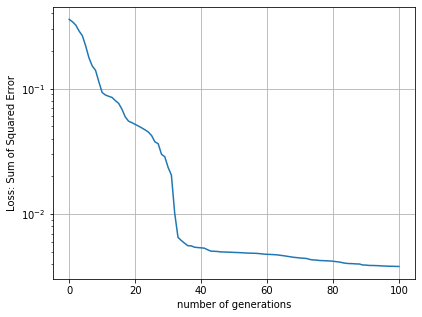

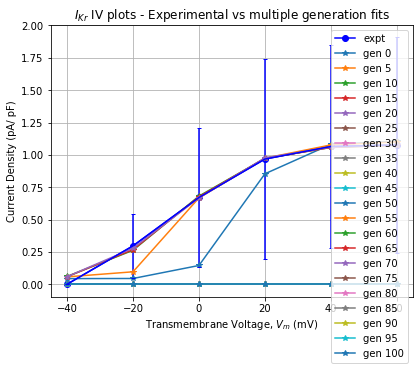

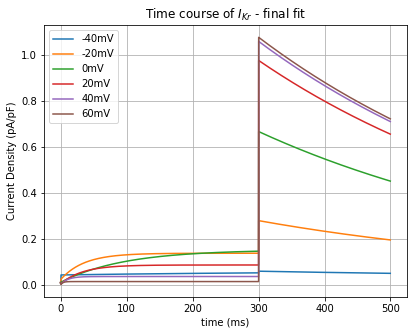

In [15]:
import timeit
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')


timer_start = timeit.default_timer()
# inputs, x
V = np.arange(-40, 61, 20)    # mV, Command Voltage

# actual Y
Ikr_act = np.array(
    [0.0000, 0.296491453, 0.670409, 0.967468331, 1.064629846, 1.076653804 ])
Ikr_err = np.array([0.000, 0.246868565, 0.539902624, 0.771099748, 0.782198549, 0.832950241])

# Population
# Parameter initialization
C = np.empty((140, 14))
C[:, 0] = np.random.uniform(0, 0.1, C.shape[0])     #g
C[:, 1] = np.random.uniform(5, 15, C.shape[0]) #ax
C[:, 2] = np.random.uniform(3, 8, C.shape[0])     #bx
C[:, 3] = np.random.uniform(500, 600, C.shape[0])     #ex
C[:, 4] = np.random.uniform(15, 27, C.shape[0])       #ta
C[:, 5] = np.random.uniform(7, 12, C.shape[0])         #td
C[:, 6] = np.random.uniform(4, 9, C.shape[0])      #te
C[:, 7] = np.random.uniform(8, 15, C.shape[0])         #tf
C[:, 8] = np.random.uniform(7, 12, C.shape[0])      #ti
C[:, 9] = np.random.uniform(200, 280, C.shape[0])         #tj
C[:, 10] = np.random.uniform(30, 60, C.shape[0])       #tk
C[:, 11] = np.random.uniform(5, 40, C.shape[0])         #tn
C[:, 12] = np.random.uniform(50, 85, C.shape[0])          #tp
C[:, 13] = np.random.uniform(10, 30, C.shape[0])           #ra

##population = np.transpose(C)

Ikr = np.empty((C.shape[0], 6))
population = C  # initial Population

# fitness
def pop_fitness(ppln):
    for i in range(C.shape[0]):
        Ikr[i,:], time, plt_Ikr = Ikr_func(ppln[i, 0], ppln[i, 1], ppln[i, 2], ppln[i, 3], ppln[i, 4],
                                 ppln[i, 5], ppln[i, 6], ppln[i, 7], ppln[i, 8], ppln[i, 9],
                                 ppln[i, 10], ppln[i, 11], ppln[i, 12], ppln[i, 13])
    SSE = np.sum((Ikr - Ikr_act) ** 2, axis=1)
    return SSE


def select_mating_pool(popn, fitness, num_parents):
    parents = np.empty((num_parents, popn.shape[1]))
    for parent_no in range(num_parents):
        max_fit_idx = np.where(fitness == np.min(fitness))  # find max and return its index
        max_fit_idx = max_fit_idx[0][0]  # Select the first index if repetitive
        parents[parent_no, :] = popn[max_fit_idx, :]
        fitness[max_fit_idx] = -99999999999
    return parents


# todo: Vary the crossover point randomly or set it to the typical middle point ie offspring[1]/2
def crossover(parents,
              offspring_size):  # in the case offspring size = (k, 3) where k is the number of desired offsprings
    offspring = np.empty(offspring_size)
    #pt1 = np.random.randint(1, offspring_size[1]/2)  # randomize the crossover point, typically the middle is chosen
    #pt2
    #crossover_point1 = np.uint8(offspring_size[1] / pt)
    crossover_point1 = np.uint8(np.random.randint(1, offspring_size[1]/2))
    crossover_point2 = np.uint8(np.random.randint(offspring_size[1]/2, offspring_size[1]))

    for n in range(parents.shape[0]):
        # parent selection
        parent1_idx = n % parents.shape[0]  # using modulus helps implement a ring parent selection fashion
        parent2_idx = (n + 1) % parents.shape[0]
        # offspring will have a up to the crossover point proportion from parent1 and parent2 respectively
        # Actual crossover
        # todo: generate two offsprings instead of one
        offspring[n, 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n, crossover_point1:crossover_point2] = parents[parent2_idx, crossover_point1:crossover_point2]
        offspring[n, crossover_point2:] = parents[parent1_idx, crossover_point2:]
        #second offspring
        offspring[n + parents.shape[0], 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n + parents.shape[0], crossover_point1:]  = parents[parent2_idx, crossover_point1:]
    return offspring


def mutation(offspring_crossover):
    # single gene random change per offspring
    for idx in range(offspring_crossover.shape[0]):
        gene_select = np.random.randint(0, population.shape[1])  # vary range of random value for gene variation
        rand_mutn_val =( (gene_select == 0)*np.random.uniform(-0.01, 0.01) +    #gkr
                         (gene_select == 1)*np.random.uniform(-2, 2) +      #xa
                         (gene_select == 2)*np.random.uniform(-1.5, 1.5) +          #xd
                         (gene_select == 3)*np.random.uniform(-20, 20) +          #xe
                         (gene_select == 4)*np.random.uniform(-2.0, 2.0) +        #ta
                         (gene_select == 5)*np.random.uniform(-2.0, 2.0) +          #td
                         (gene_select == 6)*np.random.uniform(-1.0, 1.0) +      #te
                         (gene_select == 7)*np.random.uniform(-2.0, 2.0) +      #tf
                         (gene_select == 8)*np.random.uniform(-2.0, 2.0) +          #ti
                         (gene_select == 9)*np.random.uniform(-20, 20) +      #tj
                         (gene_select == 10)*np.random.uniform(-2, 2) +       #tk
                         (gene_select == 11)*np.random.uniform(-1.5, 1.5) +         #tn
                         (gene_select == 12)*np.random.uniform(-5, 5) +         #tp
                         (gene_select == 13)*np.random.uniform(-2, 2)     #ra
                         )
        # todo: try mutating some offsprings and not all
        offspring_crossover[idx, gene_select] = offspring_crossover[idx, gene_select] + rand_mutn_val
    return offspring_crossover

i_plt = 0
gen_mod = 5
num_of_gens = 101
no_plts = num_of_gens/gen_mod
no_plts = np.int16(no_plts)
gen_curr_arr = np.zeros((6, num_of_gens))
num_mating_parents = int(C.shape[0]/5)

best_gen_fitness = []
for generation in range(num_of_gens):
#     print('generation: ', generation)
    fitness = pop_fitness(population)  # calculate fitness (SSE)
    #print(fitness)
    fitness = np.where(np.isnan(fitness), 1e100, fitness) #handles the dreaded nan's
    #fitness = np.where(np.isinf(fitness), 0, fitness)
    best_gn_fit_idx = np.where(fitness == np.min(fitness))
#     print(best_gn_fit_idx[0].size)
#     print(best_gn_fit_idx[0])
    if best_gn_fit_idx[0].size == 0:
        indx = np.random.randint(0, C.shape[0])
    else:
        indx = best_gn_fit_idx[0][0]
        
#     print(indx)
#     print(fitness[indx])
    fit_val = fitness[indx]
    best_gen_fitness.append(fitness[indx])
    parents = select_mating_pool(population, fitness, num_mating_parents)  # choose mating parents based on best min SSE
#     print(parents.shape[0])
    offspring_crossed = crossover(parents, offspring_size=(2*parents.shape[0], population.shape[1]))
    offspring_mutated = mutation(offspring_crossed)
    # assumption in the above 3 lines, the number of parents, offsprings and mutants are same
    # create new population with parents, offsprings and their mutants
    population[0:parents.shape[0], :] = parents
    population[parents.shape[0]: 3 * parents.shape[0], :] = offspring_crossed
    population[3 * parents.shape[0]:, :] = offspring_mutated


    if generation%gen_mod == 0:
        print('generation: ', generation)
        best_gn_fit_idx = np.where(fitness == np.min(fitness))
        b_idx = best_gn_fit_idx
        gen_num = np.arange(len(best_gen_fitness))
        timer_stop = timeit.default_timer()
        print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
        print('fitness: ',fit_val)
#         print(fitness)
#         plt.plot(gen_num, best_gen_fitness)
#         plt.xlabel('number of generations')
#         plt.ylabel('Loss: Sum of Squared Error (log scale)')
#         plt.yscale('log')
#         plt.grid()
#         plt.show()
        y_fit, time_fit, plt_Ikr_fit = Ikr_func(population[b_idx, 0], population[b_idx, 1], population[b_idx, 2],
                               population[b_idx, 3], population[b_idx, 4], population[b_idx, 5],
                               population[b_idx, 6], population[b_idx, 7], population[b_idx, 8],
                               population[b_idx, 9], population[b_idx, 10], population[b_idx, 11], 
                               population[b_idx, 12], population[b_idx, 13])
        gen_curr_arr[:, i_plt] = y_fit
#         print(population[indx, :])
#         plt.figure()
#         plt.plot(V, Ikr_act, '-*', V, y_fit, '-o')
#         plt.legend(['Experimental', 'Model-fitted'], loc='best')
#         plt.errorbar(V, Ikr_act, yerr=Ikr_err, capsize=2, color = 'blue')
#         plt.xlabel('Command Voltage, Vc (mV)')
#         plt.ylabel('Current Density (pA/pF)')
#         plt.title('$I_{Kr}$ IV plot: Experimental vs Stewart Model fitted')
#         plt.grid()
#         plt.show()
        
#         plt.figure(figsize=(6.5, 5))
#         plt.plot(time_fit, plt_Ikr_fit)
#         plt.xlabel('time(ms)')
#         plt.ylabel('Current Density (pA/pF)')
#         plt.title('Time Course of $I_f$ under various clamp voltages')
#         plt.legend(['-40mV', '-20mV', '0mV', '20mV', '40mV', '60mV'], loc='best')
#         plt.grid()
#         plt.show()
        i_plt = i_plt + 1

timer_stop = timeit.default_timer()        
print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
#find the final optimized parameters - chromosomes
fitness = pop_fitness(population)
best_match_idx = np.where(fitness == np.min(fitness))
Best_Sol = population[best_match_idx[0][0], :]
final_fitness = fitness[best_match_idx[0][0]]

IkrIni, time, IKrIni_time = Ikr_func(0.035, 10, 5, 550, 22, 9, 6, 11, 9, 230, 40, 20, 74, 24)

Ikrfit, time, IKrfit_time  = Ikr_func(Best_Sol[0], Best_Sol[1],  Best_Sol[2],  Best_Sol[3],
                                      Best_Sol[4],  Best_Sol[5], Best_Sol[6],  Best_Sol[7], Best_Sol[8],
                                      Best_Sol[9], Best_Sol[10], Best_Sol[11], Best_Sol[12], Best_Sol[13])
Ikr_act = np.array(
    [0.0000, 0.296491453, 0.670409, 0.967468331, 1.064629846, 1.076653804 ])
Ikr_err = np.array([0.000, 0.246868565, 0.539902624, 0.771099748, 0.782198549, 0.832950241])

Vcm = np.arange(-40, 61, 20)

ini_r2 = r2_score(Ikr_act, IkrIni)
fit_r2 = r2_score(Ikr_act, Ikrfit)

gen_num = np.arange(len(best_gen_fitness))

#Save fitting outcomes for future plots and analysis
GA_trial_n = GA_trial()
GA_trial_n.gen_num = gen_num
GA_trial_n.loss = best_gen_fitness
GA_trial_n.final_fit_val = final_fitness
GA_trial_n.R2_sq_ini = ini_r2
GA_trial_n.R2_sq_fin = fit_r2
GA_trial_n.Parameters = Best_Sol
GA_trial_n.time = time
GA_trial_n.cur_time_ini = IKrIni_time
GA_trial_n.cur_time_fit = IKrfit_time
GA_trial_n.Vcm = Vcm
GA_trial_n.I_peaks_fin = y_fit
GA_trial_n.I_peaks_ini = IkrIni

pickle.dump(GA_trial_n, open('IKr_GA_trial_2.p', 'wb'))

print("Best Solution: ", Best_Sol)
print("Best solution fitness: ", final_fitness)

print('Initial Model Goodness of fit, R_sq = %s' %ini_r2)
print('GA fitted Model Goodness of fit, R_sq = %s' %fit_r2)

plt.figure(figsize=(6.5,5))
plt.plot(gen_num, best_gen_fitness)
plt.yscale('log')
plt.xlabel('number of generations')
plt.ylabel('Loss: Sum of Squared Error')
plt.grid()
plt.show()

plt.figure(figsize = (6.5,5))
plt.plot(V, Ikr_act, 'b-o', label = 'expt')
for cnt in np.arange(0,gen_curr_arr.shape[1], gen_mod):
    plt.plot(V, gen_curr_arr[:, cnt], '-*', label='gen %s' %(cnt))

plt.xlabel('Transmembrane Voltage, $V_m$ (mV)')
plt.ylabel('Current Density (pA/ pF)')
plt.title('$I_{Kr}$ IV plots - Experimental vs multiple generation fits')
plt.grid()
plt.legend(loc='best')
plt.errorbar(V, Ikr_act, yerr=Ikr_err, capsize=2, color = 'blue')
plt.show()

plt.figure(figsize=(6.5,5))
plt.plot(time_fit, plt_Ikr_fit)
plt.xlabel('time (ms)')
plt.ylabel('Current Density (pA/pF)')
plt.title('Time course of $I_{Kr}$ - final fit')
plt.legend(['-40mV', '-20mV', '0mV', '20mV', '40mV', '60mV'], loc='best')
plt.grid()
plt.show()


**GA 3**

generation:  0
Runtime:  3.2208123216666666 mins
fitness:  0.35065460654678254
generation:  5
Runtime:  19.77406540666667 mins
fitness:  0.15771322971070584
generation:  10
Runtime:  36.100951300000006 mins
fitness:  0.0714843527300727
generation:  15
Runtime:  52.764557906666674 mins
fitness:  0.05411386845336617
generation:  20
Runtime:  68.92698200333334 mins
fitness:  0.04454495231289457
generation:  25
Runtime:  84.51743814833334 mins
fitness:  0.028043165461905287
generation:  30
Runtime:  99.55443419500001 mins
fitness:  0.008888569596104413
generation:  35
Runtime:  114.648168345 mins
fitness:  0.005001149635508531
generation:  40
Runtime:  130.20346030166667 mins
fitness:  0.004818170939226902
generation:  45
Runtime:  145.98304032166666 mins
fitness:  0.004666646125277732
generation:  50
Runtime:  162.25460353333335 mins
fitness:  0.004446943221311804
generation:  55
Runtime:  178.816429975 mins
fitness:  0.0043013836285393315
generation:  60
Runtime:  195.15969802 mins
fitne

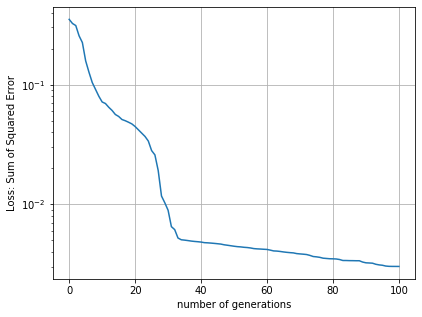

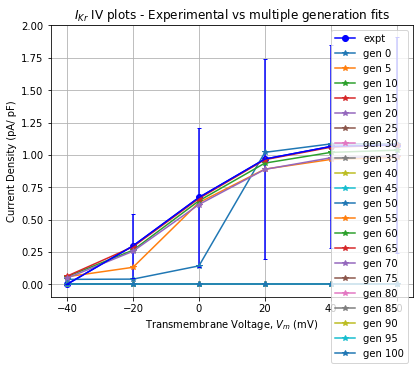

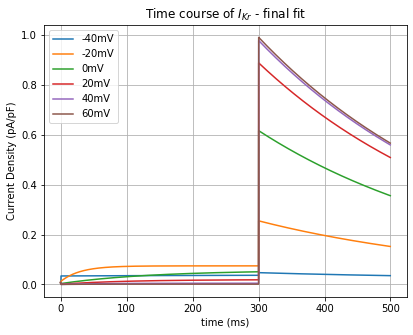

In [6]:
import timeit
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')


timer_start = timeit.default_timer()
# inputs, x
V = np.arange(-40, 61, 20)    # mV, Command Voltage

# actual Y
Ikr_act = np.array(
    [0.0000, 0.296491453, 0.670409, 0.967468331, 1.064629846, 1.076653804 ])
Ikr_err = np.array([0.000, 0.246868565, 0.539902624, 0.771099748, 0.782198549, 0.832950241])

# Population
# Parameter initialization
C = np.empty((140, 14))
C[:, 0] = np.random.uniform(0, 0.1, C.shape[0])     #g
C[:, 1] = np.random.uniform(5, 15, C.shape[0]) #ax
C[:, 2] = np.random.uniform(3, 8, C.shape[0])     #bx
C[:, 3] = np.random.uniform(500, 600, C.shape[0])     #ex
C[:, 4] = np.random.uniform(15, 27, C.shape[0])       #ta
C[:, 5] = np.random.uniform(7, 12, C.shape[0])         #td
C[:, 6] = np.random.uniform(4, 9, C.shape[0])      #te
C[:, 7] = np.random.uniform(8, 15, C.shape[0])         #tf
C[:, 8] = np.random.uniform(7, 12, C.shape[0])      #ti
C[:, 9] = np.random.uniform(200, 280, C.shape[0])         #tj
C[:, 10] = np.random.uniform(30, 60, C.shape[0])       #tk
C[:, 11] = np.random.uniform(5, 40, C.shape[0])         #tn
C[:, 12] = np.random.uniform(50, 85, C.shape[0])          #tp
C[:, 13] = np.random.uniform(10, 30, C.shape[0])           #ra

##population = np.transpose(C)

Ikr = np.empty((C.shape[0], 6))
population = C  # initial Population

# fitness
def pop_fitness(ppln):
    for i in range(C.shape[0]):
        Ikr[i,:], time, plt_Ikr = Ikr_func(ppln[i, 0], ppln[i, 1], ppln[i, 2], ppln[i, 3], ppln[i, 4],
                                 ppln[i, 5], ppln[i, 6], ppln[i, 7], ppln[i, 8], ppln[i, 9],
                                 ppln[i, 10], ppln[i, 11], ppln[i, 12], ppln[i, 13])
    SSE = np.sum((Ikr - Ikr_act) ** 2, axis=1)
    return SSE


def select_mating_pool(popn, fitness, num_parents):
    parents = np.empty((num_parents, popn.shape[1]))
    for parent_no in range(num_parents):
        max_fit_idx = np.where(fitness == np.min(fitness))  # find max and return its index
        max_fit_idx = max_fit_idx[0][0]  # Select the first index if repetitive
        parents[parent_no, :] = popn[max_fit_idx, :]
        fitness[max_fit_idx] = -99999999999
    return parents


# todo: Vary the crossover point randomly or set it to the typical middle point ie offspring[1]/2
def crossover(parents,
              offspring_size):  # in the case offspring size = (k, 3) where k is the number of desired offsprings
    offspring = np.empty(offspring_size)
    #pt1 = np.random.randint(1, offspring_size[1]/2)  # randomize the crossover point, typically the middle is chosen
    #pt2
    #crossover_point1 = np.uint8(offspring_size[1] / pt)
    crossover_point1 = np.uint8(np.random.randint(1, offspring_size[1]/2))
    crossover_point2 = np.uint8(np.random.randint(offspring_size[1]/2, offspring_size[1]))

    for n in range(parents.shape[0]):
        # parent selection
        parent1_idx = n % parents.shape[0]  # using modulus helps implement a ring parent selection fashion
        parent2_idx = (n + 1) % parents.shape[0]
        # offspring will have a up to the crossover point proportion from parent1 and parent2 respectively
        # Actual crossover
        # todo: generate two offsprings instead of one
        offspring[n, 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n, crossover_point1:crossover_point2] = parents[parent2_idx, crossover_point1:crossover_point2]
        offspring[n, crossover_point2:] = parents[parent1_idx, crossover_point2:]
        #second offspring
        offspring[n + parents.shape[0], 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n + parents.shape[0], crossover_point1:]  = parents[parent2_idx, crossover_point1:]
    return offspring


def mutation(offspring_crossover):
    # single gene random change per offspring
    for idx in range(offspring_crossover.shape[0]):
        gene_select = np.random.randint(0, population.shape[1])  # vary range of random value for gene variation
        rand_mutn_val =( (gene_select == 0)*np.random.uniform(-0.01, 0.01) +    #gkr
                         (gene_select == 1)*np.random.uniform(-2, 2) +      #xa
                         (gene_select == 2)*np.random.uniform(-1.5, 1.5) +          #xd
                         (gene_select == 3)*np.random.uniform(-20, 20) +          #xe
                         (gene_select == 4)*np.random.uniform(-2.0, 2.0) +        #ta
                         (gene_select == 5)*np.random.uniform(-2.0, 2.0) +          #td
                         (gene_select == 6)*np.random.uniform(-1.0, 1.0) +      #te
                         (gene_select == 7)*np.random.uniform(-2.0, 2.0) +      #tf
                         (gene_select == 8)*np.random.uniform(-2.0, 2.0) +          #ti
                         (gene_select == 9)*np.random.uniform(-20, 20) +      #tj
                         (gene_select == 10)*np.random.uniform(-2, 2) +       #tk
                         (gene_select == 11)*np.random.uniform(-1.5, 1.5) +         #tn
                         (gene_select == 12)*np.random.uniform(-5, 5) +         #tp
                         (gene_select == 13)*np.random.uniform(-2, 2)     #ra
                         )
        # todo: try mutating some offsprings and not all
        offspring_crossover[idx, gene_select] = offspring_crossover[idx, gene_select] + rand_mutn_val
    return offspring_crossover

i_plt = 0
gen_mod = 5
num_of_gens = 101
no_plts = num_of_gens/gen_mod
no_plts = np.int16(no_plts)
gen_curr_arr = np.zeros((6, num_of_gens))
num_mating_parents = int(C.shape[0]/5)

best_gen_fitness = []
for generation in range(num_of_gens):
#     print('generation: ', generation)
    fitness = pop_fitness(population)  # calculate fitness (SSE)
    #print(fitness)
    fitness = np.where(np.isnan(fitness), 1e100, fitness) #handles the dreaded nan's
    #fitness = np.where(np.isinf(fitness), 0, fitness)
    best_gn_fit_idx = np.where(fitness == np.min(fitness))
#     print(best_gn_fit_idx[0].size)
#     print(best_gn_fit_idx[0])
    if best_gn_fit_idx[0].size == 0:
        indx = np.random.randint(0, C.shape[0])
    else:
        indx = best_gn_fit_idx[0][0]
        
#     print(indx)
#     print(fitness[indx])
    fit_val = fitness[indx]
    best_gen_fitness.append(fitness[indx])
    parents = select_mating_pool(population, fitness, num_mating_parents)  # choose mating parents based on best min SSE
#     print(parents.shape[0])
    offspring_crossed = crossover(parents, offspring_size=(2*parents.shape[0], population.shape[1]))
    offspring_mutated = mutation(offspring_crossed)
    # assumption in the above 3 lines, the number of parents, offsprings and mutants are same
    # create new population with parents, offsprings and their mutants
    population[0:parents.shape[0], :] = parents
    population[parents.shape[0]: 3 * parents.shape[0], :] = offspring_crossed
    population[3 * parents.shape[0]:, :] = offspring_mutated


    if generation%gen_mod == 0:
        print('generation: ', generation)
        best_gn_fit_idx = np.where(fitness == np.min(fitness))
        b_idx = best_gn_fit_idx
        gen_num = np.arange(len(best_gen_fitness))
        timer_stop = timeit.default_timer()
        print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
        print('fitness: ',fit_val)
#         print(fitness)
#         plt.plot(gen_num, best_gen_fitness)
#         plt.xlabel('number of generations')
#         plt.ylabel('Loss: Sum of Squared Error (log scale)')
#         plt.yscale('log')
#         plt.grid()
#         plt.show()
        y_fit, time_fit, plt_Ikr_fit = Ikr_func(population[b_idx, 0], population[b_idx, 1], population[b_idx, 2],
                               population[b_idx, 3], population[b_idx, 4], population[b_idx, 5],
                               population[b_idx, 6], population[b_idx, 7], population[b_idx, 8],
                               population[b_idx, 9], population[b_idx, 10], population[b_idx, 11], 
                               population[b_idx, 12], population[b_idx, 13])
        gen_curr_arr[:, i_plt] = y_fit
#         print(population[indx, :])
#         plt.figure()
#         plt.plot(V, Ikr_act, '-*', V, y_fit, '-o')
#         plt.legend(['Experimental', 'Model-fitted'], loc='best')
#         plt.errorbar(V, Ikr_act, yerr=Ikr_err, capsize=2, color = 'blue')
#         plt.xlabel('Command Voltage, Vc (mV)')
#         plt.ylabel('Current Density (pA/pF)')
#         plt.title('$I_{Kr}$ IV plot: Experimental vs Stewart Model fitted')
#         plt.grid()
#         plt.show()
        
#         plt.figure(figsize=(6.5, 5))
#         plt.plot(time_fit, plt_Ikr_fit)
#         plt.xlabel('time(ms)')
#         plt.ylabel('Current Density (pA/pF)')
#         plt.title('Time Course of $I_f$ under various clamp voltages')
#         plt.legend(['-40mV', '-20mV', '0mV', '20mV', '40mV', '60mV'], loc='best')
#         plt.grid()
#         plt.show()
        i_plt = i_plt + 1

timer_stop = timeit.default_timer()        
print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
#find the final optimized parameters - chromosomes
fitness = pop_fitness(population)
best_match_idx = np.where(fitness == np.min(fitness))
Best_Sol = population[best_match_idx[0][0], :]
final_fitness = fitness[best_match_idx[0][0]]

IkrIni, time, IKrIni_time = Ikr_func(0.035, 10, 5, 550, 22, 9, 6, 11, 9, 230, 40, 20, 74, 24)

Ikrfit, time, IKrfit_time  = Ikr_func(Best_Sol[0], Best_Sol[1],  Best_Sol[2],  Best_Sol[3],
                                      Best_Sol[4],  Best_Sol[5], Best_Sol[6],  Best_Sol[7], Best_Sol[8],
                                      Best_Sol[9], Best_Sol[10], Best_Sol[11], Best_Sol[12], Best_Sol[13])
Ikr_act = np.array(
    [0.0000, 0.296491453, 0.670409, 0.967468331, 1.064629846, 1.076653804 ])
Ikr_err = np.array([0.000, 0.246868565, 0.539902624, 0.771099748, 0.782198549, 0.832950241])

Vcm = np.arange(-40, 61, 20)

ini_r2 = r2_score(Ikr_act, IkrIni)
fit_r2 = r2_score(Ikr_act, Ikrfit)

gen_num = np.arange(len(best_gen_fitness))

#Save fitting outcomes for future plots and analysis
GA_trial_n = GA_trial()
GA_trial_n.gen_num = gen_num
GA_trial_n.loss = best_gen_fitness
GA_trial_n.final_fit_val = final_fitness
GA_trial_n.R2_sq_ini = ini_r2
GA_trial_n.R2_sq_fin = fit_r2
GA_trial_n.Parameters = Best_Sol
GA_trial_n.time = time
GA_trial_n.cur_time_ini = IKrIni_time
GA_trial_n.cur_time_fit = IKrfit_time
GA_trial_n.Vcm = Vcm
GA_trial_n.I_peaks_fin = y_fit
GA_trial_n.I_peaks_ini = IkrIni

pickle.dump(GA_trial_n, open('IKr_GA_trial_3.p', 'wb'))

print("Best Solution: ", Best_Sol)
print("Best solution fitness: ", final_fitness)

print('Initial Model Goodness of fit, R_sq = %s' %ini_r2)
print('GA fitted Model Goodness of fit, R_sq = %s' %fit_r2)

plt.figure(figsize=(6.5,5))
plt.plot(gen_num, best_gen_fitness)
plt.yscale('log')
plt.xlabel('number of generations')
plt.ylabel('Loss: Sum of Squared Error')
plt.grid()
plt.show()

plt.figure(figsize = (6.5,5))
plt.plot(V, Ikr_act, 'b-o', label = 'expt')
for cnt in np.arange(0,gen_curr_arr.shape[1], gen_mod):
    plt.plot(V, gen_curr_arr[:, cnt], '-*', label='gen %s' %(cnt))

plt.xlabel('Transmembrane Voltage, $V_m$ (mV)')
plt.ylabel('Current Density (pA/ pF)')
plt.title('$I_{Kr}$ IV plots - Experimental vs multiple generation fits')
plt.grid()
plt.legend(loc='best')
plt.errorbar(V, Ikr_act, yerr=Ikr_err, capsize=2, color = 'blue')
plt.show()

plt.figure(figsize=(6.5,5))
plt.plot(time_fit, plt_Ikr_fit)
plt.xlabel('time (ms)')
plt.ylabel('Current Density (pA/pF)')
plt.title('Time course of $I_{Kr}$ - final fit')
plt.legend(['-40mV', '-20mV', '0mV', '20mV', '40mV', '60mV'], loc='best')
plt.grid()
plt.show()


**GA 4**

generation:  0
Runtime:  3.1309993083333336 mins
fitness:  0.3531958004928778
generation:  5
Runtime:  29.683153651666668 mins
fitness:  0.15450667004593657
generation:  10
Runtime:  45.51290619833333 mins
fitness:  0.07110853608715442
generation:  15
Runtime:  61.32551437 mins
fitness:  0.05492199388369912
generation:  20
Runtime:  76.857921865 mins
fitness:  0.046849546341782906
generation:  25
Runtime:  92.34894801166666 mins
fitness:  0.03084378894684187
generation:  30
Runtime:  107.70338147833333 mins
fitness:  0.005532099190484492
generation:  35
Runtime:  123.06987887166666 mins
fitness:  0.005149857733634214
generation:  40
Runtime:  138.73429480000001 mins
fitness:  0.005037699581491131
generation:  45
Runtime:  155.19025641666667 mins
fitness:  0.004962106712805209
generation:  50
Runtime:  171.38618345833336 mins
fitness:  0.004894995868848634
generation:  55
Runtime:  187.54702081666667 mins
fitness:  0.0048157218668084196
generation:  60
Runtime:  203.61528552500002 mins


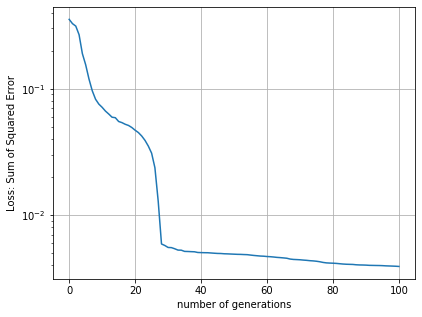

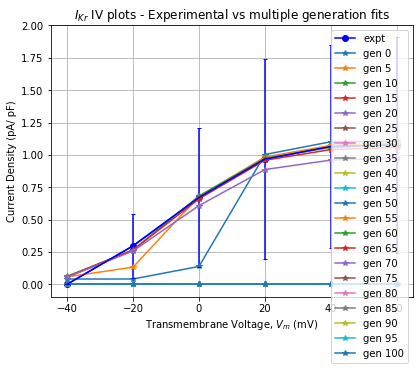

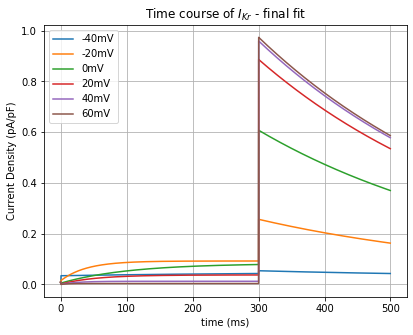

In [5]:
import timeit
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')


timer_start = timeit.default_timer()
# inputs, x
V = np.arange(-40, 61, 20)    # mV, Command Voltage

# actual Y
Ikr_act = np.array(
    [0.0000, 0.296491453, 0.670409, 0.967468331, 1.064629846, 1.076653804 ])
Ikr_err = np.array([0.000, 0.246868565, 0.539902624, 0.771099748, 0.782198549, 0.832950241])

# Population
# Parameter initialization
C = np.empty((140, 14))
C[:, 0] = np.random.uniform(0, 0.1, C.shape[0])     #g
C[:, 1] = np.random.uniform(5, 15, C.shape[0]) #ax
C[:, 2] = np.random.uniform(3, 8, C.shape[0])     #bx
C[:, 3] = np.random.uniform(500, 600, C.shape[0])     #ex
C[:, 4] = np.random.uniform(15, 27, C.shape[0])       #ta
C[:, 5] = np.random.uniform(7, 12, C.shape[0])         #td
C[:, 6] = np.random.uniform(4, 9, C.shape[0])      #te
C[:, 7] = np.random.uniform(8, 15, C.shape[0])         #tf
C[:, 8] = np.random.uniform(7, 12, C.shape[0])      #ti
C[:, 9] = np.random.uniform(200, 280, C.shape[0])         #tj
C[:, 10] = np.random.uniform(30, 60, C.shape[0])       #tk
C[:, 11] = np.random.uniform(5, 40, C.shape[0])         #tn
C[:, 12] = np.random.uniform(50, 85, C.shape[0])          #tp
C[:, 13] = np.random.uniform(10, 30, C.shape[0])           #ra

##population = np.transpose(C)

Ikr = np.empty((C.shape[0], 6))
population = C  # initial Population

# fitness
def pop_fitness(ppln):
    for i in range(C.shape[0]):
        Ikr[i,:], time, plt_Ikr = Ikr_func(ppln[i, 0], ppln[i, 1], ppln[i, 2], ppln[i, 3], ppln[i, 4],
                                 ppln[i, 5], ppln[i, 6], ppln[i, 7], ppln[i, 8], ppln[i, 9],
                                 ppln[i, 10], ppln[i, 11], ppln[i, 12], ppln[i, 13])
    SSE = np.sum((Ikr - Ikr_act) ** 2, axis=1)
    return SSE


def select_mating_pool(popn, fitness, num_parents):
    parents = np.empty((num_parents, popn.shape[1]))
    for parent_no in range(num_parents):
        max_fit_idx = np.where(fitness == np.min(fitness))  # find max and return its index
        max_fit_idx = max_fit_idx[0][0]  # Select the first index if repetitive
        parents[parent_no, :] = popn[max_fit_idx, :]
        fitness[max_fit_idx] = -99999999999
    return parents


# todo: Vary the crossover point randomly or set it to the typical middle point ie offspring[1]/2
def crossover(parents,
              offspring_size):  # in the case offspring size = (k, 3) where k is the number of desired offsprings
    offspring = np.empty(offspring_size)
    #pt1 = np.random.randint(1, offspring_size[1]/2)  # randomize the crossover point, typically the middle is chosen
    #pt2
    #crossover_point1 = np.uint8(offspring_size[1] / pt)
    crossover_point1 = np.uint8(np.random.randint(1, offspring_size[1]/2))
    crossover_point2 = np.uint8(np.random.randint(offspring_size[1]/2, offspring_size[1]))

    for n in range(parents.shape[0]):
        # parent selection
        parent1_idx = n % parents.shape[0]  # using modulus helps implement a ring parent selection fashion
        parent2_idx = (n + 1) % parents.shape[0]
        # offspring will have a up to the crossover point proportion from parent1 and parent2 respectively
        # Actual crossover
        # todo: generate two offsprings instead of one
        offspring[n, 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n, crossover_point1:crossover_point2] = parents[parent2_idx, crossover_point1:crossover_point2]
        offspring[n, crossover_point2:] = parents[parent1_idx, crossover_point2:]
        #second offspring
        offspring[n + parents.shape[0], 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n + parents.shape[0], crossover_point1:]  = parents[parent2_idx, crossover_point1:]
    return offspring


def mutation(offspring_crossover):
    # single gene random change per offspring
    for idx in range(offspring_crossover.shape[0]):
        gene_select = np.random.randint(0, population.shape[1])  # vary range of random value for gene variation
        rand_mutn_val =( (gene_select == 0)*np.random.uniform(-0.01, 0.01) +    #gkr
                         (gene_select == 1)*np.random.uniform(-2, 2) +      #xa
                         (gene_select == 2)*np.random.uniform(-1.5, 1.5) +          #xd
                         (gene_select == 3)*np.random.uniform(-20, 20) +          #xe
                         (gene_select == 4)*np.random.uniform(-2.0, 2.0) +        #ta
                         (gene_select == 5)*np.random.uniform(-2.0, 2.0) +          #td
                         (gene_select == 6)*np.random.uniform(-1.0, 1.0) +      #te
                         (gene_select == 7)*np.random.uniform(-2.0, 2.0) +      #tf
                         (gene_select == 8)*np.random.uniform(-2.0, 2.0) +          #ti
                         (gene_select == 9)*np.random.uniform(-20, 20) +      #tj
                         (gene_select == 10)*np.random.uniform(-2, 2) +       #tk
                         (gene_select == 11)*np.random.uniform(-1.5, 1.5) +         #tn
                         (gene_select == 12)*np.random.uniform(-5, 5) +         #tp
                         (gene_select == 13)*np.random.uniform(-2, 2)     #ra
                         )
        # todo: try mutating some offsprings and not all
        offspring_crossover[idx, gene_select] = offspring_crossover[idx, gene_select] + rand_mutn_val
    return offspring_crossover

i_plt = 0
gen_mod = 5
num_of_gens = 101
no_plts = num_of_gens/gen_mod
no_plts = np.int16(no_plts)
gen_curr_arr = np.zeros((6, num_of_gens))
num_mating_parents = int(C.shape[0]/5)

best_gen_fitness = []
for generation in range(num_of_gens):
#     print('generation: ', generation)
    fitness = pop_fitness(population)  # calculate fitness (SSE)
    #print(fitness)
    fitness = np.where(np.isnan(fitness), 1e100, fitness) #handles the dreaded nan's
    #fitness = np.where(np.isinf(fitness), 0, fitness)
    best_gn_fit_idx = np.where(fitness == np.min(fitness))
#     print(best_gn_fit_idx[0].size)
#     print(best_gn_fit_idx[0])
    if best_gn_fit_idx[0].size == 0:
        indx = np.random.randint(0, C.shape[0])
    else:
        indx = best_gn_fit_idx[0][0]
        
#     print(indx)
#     print(fitness[indx])
    fit_val = fitness[indx]
    best_gen_fitness.append(fitness[indx])
    parents = select_mating_pool(population, fitness, num_mating_parents)  # choose mating parents based on best min SSE
#     print(parents.shape[0])
    offspring_crossed = crossover(parents, offspring_size=(2*parents.shape[0], population.shape[1]))
    offspring_mutated = mutation(offspring_crossed)
    # assumption in the above 3 lines, the number of parents, offsprings and mutants are same
    # create new population with parents, offsprings and their mutants
    population[0:parents.shape[0], :] = parents
    population[parents.shape[0]: 3 * parents.shape[0], :] = offspring_crossed
    population[3 * parents.shape[0]:, :] = offspring_mutated


    if generation%gen_mod == 0:
        print('generation: ', generation)
        best_gn_fit_idx = np.where(fitness == np.min(fitness))
        b_idx = best_gn_fit_idx
        gen_num = np.arange(len(best_gen_fitness))
        timer_stop = timeit.default_timer()
        print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
        print('fitness: ',fit_val)
#         print(fitness)
#         plt.plot(gen_num, best_gen_fitness)
#         plt.xlabel('number of generations')
#         plt.ylabel('Loss: Sum of Squared Error (log scale)')
#         plt.yscale('log')
#         plt.grid()
#         plt.show()
        y_fit, time_fit, plt_Ikr_fit = Ikr_func(population[b_idx, 0], population[b_idx, 1], population[b_idx, 2],
                               population[b_idx, 3], population[b_idx, 4], population[b_idx, 5],
                               population[b_idx, 6], population[b_idx, 7], population[b_idx, 8],
                               population[b_idx, 9], population[b_idx, 10], population[b_idx, 11], 
                               population[b_idx, 12], population[b_idx, 13])
        gen_curr_arr[:, i_plt] = y_fit
#         print(population[indx, :])
#         plt.figure()
#         plt.plot(V, Ikr_act, '-*', V, y_fit, '-o')
#         plt.legend(['Experimental', 'Model-fitted'], loc='best')
#         plt.errorbar(V, Ikr_act, yerr=Ikr_err, capsize=2, color = 'blue')
#         plt.xlabel('Command Voltage, Vc (mV)')
#         plt.ylabel('Current Density (pA/pF)')
#         plt.title('$I_{Kr}$ IV plot: Experimental vs Stewart Model fitted')
#         plt.grid()
#         plt.show()
        
#         plt.figure(figsize=(6.5, 5))
#         plt.plot(time_fit, plt_Ikr_fit)
#         plt.xlabel('time(ms)')
#         plt.ylabel('Current Density (pA/pF)')
#         plt.title('Time Course of $I_f$ under various clamp voltages')
#         plt.legend(['-40mV', '-20mV', '0mV', '20mV', '40mV', '60mV'], loc='best')
#         plt.grid()
#         plt.show()
        i_plt = i_plt + 1

timer_stop = timeit.default_timer()        
print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
#find the final optimized parameters - chromosomes
fitness = pop_fitness(population)
best_match_idx = np.where(fitness == np.min(fitness))
Best_Sol = population[best_match_idx[0][0], :]
final_fitness = fitness[best_match_idx[0][0]]

IkrIni, time, IKrIni_time = Ikr_func(0.035, 10, 5, 550, 22, 9, 6, 11, 9, 230, 40, 20, 74, 24)

Ikrfit, time, IKrfit_time  = Ikr_func(Best_Sol[0], Best_Sol[1],  Best_Sol[2],  Best_Sol[3],
                                      Best_Sol[4],  Best_Sol[5], Best_Sol[6],  Best_Sol[7], Best_Sol[8],
                                      Best_Sol[9], Best_Sol[10], Best_Sol[11], Best_Sol[12], Best_Sol[13])
Ikr_act = np.array(
    [0.0000, 0.296491453, 0.670409, 0.967468331, 1.064629846, 1.076653804 ])
Ikr_err = np.array([0.000, 0.246868565, 0.539902624, 0.771099748, 0.782198549, 0.832950241])

Vcm = np.arange(-40, 61, 20)

ini_r2 = r2_score(Ikr_act, IkrIni)
fit_r2 = r2_score(Ikr_act, Ikrfit)

gen_num = np.arange(len(best_gen_fitness))

#Save fitting outcomes for future plots and analysis
GA_trial_n = GA_trial()
GA_trial_n.gen_num = gen_num
GA_trial_n.loss = best_gen_fitness
GA_trial_n.final_fit_val = final_fitness
GA_trial_n.R2_sq_ini = ini_r2
GA_trial_n.R2_sq_fin = fit_r2
GA_trial_n.Parameters = Best_Sol
GA_trial_n.time = time
GA_trial_n.cur_time_ini = IKrIni_time
GA_trial_n.cur_time_fit = IKrfit_time
GA_trial_n.Vcm = Vcm
GA_trial_n.I_peaks_fin = y_fit
GA_trial_n.I_peaks_ini = IkrIni

pickle.dump(GA_trial_n, open('IKr_GA_trial_4.p', 'wb'))

print("Best Solution: ", Best_Sol)
print("Best solution fitness: ", final_fitness)

print('Initial Model Goodness of fit, R_sq = %s' %ini_r2)
print('GA fitted Model Goodness of fit, R_sq = %s' %fit_r2)

plt.figure(figsize=(6.5,5))
plt.plot(gen_num, best_gen_fitness)
plt.yscale('log')
plt.xlabel('number of generations')
plt.ylabel('Loss: Sum of Squared Error')
plt.grid()
plt.show()

plt.figure(figsize = (6.5,5))
plt.plot(V, Ikr_act, 'b-o', label = 'expt')
for cnt in np.arange(0,gen_curr_arr.shape[1], gen_mod):
    plt.plot(V, gen_curr_arr[:, cnt], '-*', label='gen %s' %(cnt))

plt.xlabel('Transmembrane Voltage, $V_m$ (mV)')
plt.ylabel('Current Density (pA/ pF)')
plt.title('$I_{Kr}$ IV plots - Experimental vs multiple generation fits')
plt.grid()
plt.legend(loc='best')
plt.errorbar(V, Ikr_act, yerr=Ikr_err, capsize=2, color = 'blue')
plt.show()

plt.figure(figsize=(6.5,5))
plt.plot(time_fit, plt_Ikr_fit)
plt.xlabel('time (ms)')
plt.ylabel('Current Density (pA/pF)')
plt.title('Time course of $I_{Kr}$ - final fit')
plt.legend(['-40mV', '-20mV', '0mV', '20mV', '40mV', '60mV'], loc='best')
plt.grid()
plt.show()


**GA 5**

generation:  0
Runtime:  2.953994855000019 mins
fitness:  0.3923766467185349
generation:  5
Runtime:  17.859880328333322 mins
fitness:  0.25940894036909934
generation:  10
Runtime:  33.03523337166668 mins
fitness:  0.07034113484400638
generation:  15
Runtime:  48.117207378333354 mins
fitness:  0.05460799797949781
generation:  20
Runtime:  62.946948285000026 mins
fitness:  0.04893009452061554
generation:  25
Runtime:  77.8793669516667 mins
fitness:  0.03684895772974971
generation:  30
Runtime:  92.63612766 mins
fitness:  0.006726897339354577
generation:  35
Runtime:  107.3253563733333 mins
fitness:  0.0048664309611368434
generation:  40
Runtime:  122.04133625499999 mins
fitness:  0.004684057294749657
generation:  45
Runtime:  137.00966481333333 mins
fitness:  0.004499904917575169
generation:  50
Runtime:  151.76537995333334 mins
fitness:  0.0043826758092131895
generation:  55
Runtime:  166.4820971383333 mins
fitness:  0.004160803406079153
generation:  60
Runtime:  181.20679949666663 min

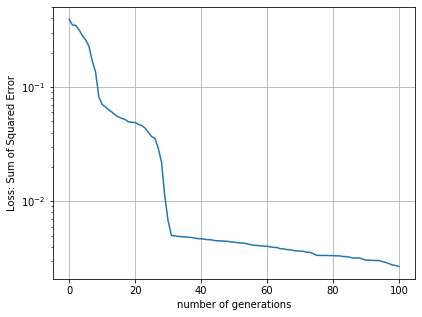

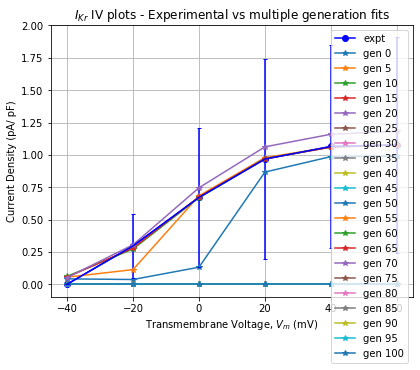

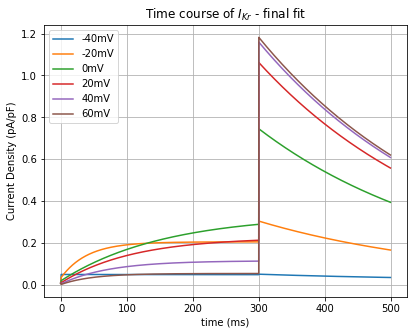

In [6]:
import timeit
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')


timer_start = timeit.default_timer()
# inputs, x
V = np.arange(-40, 61, 20)    # mV, Command Voltage

# actual Y
Ikr_act = np.array(
    [0.0000, 0.296491453, 0.670409, 0.967468331, 1.064629846, 1.076653804 ])
Ikr_err = np.array([0.000, 0.246868565, 0.539902624, 0.771099748, 0.782198549, 0.832950241])

# Population
# Parameter initialization
C = np.empty((140, 14))
C[:, 0] = np.random.uniform(0, 0.1, C.shape[0])     #g
C[:, 1] = np.random.uniform(5, 15, C.shape[0]) #ax
C[:, 2] = np.random.uniform(3, 8, C.shape[0])     #bx
C[:, 3] = np.random.uniform(500, 600, C.shape[0])     #ex
C[:, 4] = np.random.uniform(15, 27, C.shape[0])       #ta
C[:, 5] = np.random.uniform(7, 12, C.shape[0])         #td
C[:, 6] = np.random.uniform(4, 9, C.shape[0])      #te
C[:, 7] = np.random.uniform(8, 15, C.shape[0])         #tf
C[:, 8] = np.random.uniform(7, 12, C.shape[0])      #ti
C[:, 9] = np.random.uniform(200, 280, C.shape[0])         #tj
C[:, 10] = np.random.uniform(30, 60, C.shape[0])       #tk
C[:, 11] = np.random.uniform(5, 40, C.shape[0])         #tn
C[:, 12] = np.random.uniform(50, 85, C.shape[0])          #tp
C[:, 13] = np.random.uniform(10, 30, C.shape[0])           #ra

##population = np.transpose(C)

Ikr = np.empty((C.shape[0], 6))
population = C  # initial Population

# fitness
def pop_fitness(ppln):
    for i in range(C.shape[0]):
        Ikr[i,:], time, plt_Ikr = Ikr_func(ppln[i, 0], ppln[i, 1], ppln[i, 2], ppln[i, 3], ppln[i, 4],
                                 ppln[i, 5], ppln[i, 6], ppln[i, 7], ppln[i, 8], ppln[i, 9],
                                 ppln[i, 10], ppln[i, 11], ppln[i, 12], ppln[i, 13])
    SSE = np.sum((Ikr - Ikr_act) ** 2, axis=1)
    return SSE


def select_mating_pool(popn, fitness, num_parents):
    parents = np.empty((num_parents, popn.shape[1]))
    for parent_no in range(num_parents):
        max_fit_idx = np.where(fitness == np.min(fitness))  # find max and return its index
        max_fit_idx = max_fit_idx[0][0]  # Select the first index if repetitive
        parents[parent_no, :] = popn[max_fit_idx, :]
        fitness[max_fit_idx] = -99999999999
    return parents


# todo: Vary the crossover point randomly or set it to the typical middle point ie offspring[1]/2
def crossover(parents,
              offspring_size):  # in the case offspring size = (k, 3) where k is the number of desired offsprings
    offspring = np.empty(offspring_size)
    #pt1 = np.random.randint(1, offspring_size[1]/2)  # randomize the crossover point, typically the middle is chosen
    #pt2
    #crossover_point1 = np.uint8(offspring_size[1] / pt)
    crossover_point1 = np.uint8(np.random.randint(1, offspring_size[1]/2))
    crossover_point2 = np.uint8(np.random.randint(offspring_size[1]/2, offspring_size[1]))

    for n in range(parents.shape[0]):
        # parent selection
        parent1_idx = n % parents.shape[0]  # using modulus helps implement a ring parent selection fashion
        parent2_idx = (n + 1) % parents.shape[0]
        # offspring will have a up to the crossover point proportion from parent1 and parent2 respectively
        # Actual crossover
        # todo: generate two offsprings instead of one
        offspring[n, 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n, crossover_point1:crossover_point2] = parents[parent2_idx, crossover_point1:crossover_point2]
        offspring[n, crossover_point2:] = parents[parent1_idx, crossover_point2:]
        #second offspring
        offspring[n + parents.shape[0], 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n + parents.shape[0], crossover_point1:]  = parents[parent2_idx, crossover_point1:]
    return offspring


def mutation(offspring_crossover):
    # single gene random change per offspring
    for idx in range(offspring_crossover.shape[0]):
        gene_select = np.random.randint(0, population.shape[1])  # vary range of random value for gene variation
        rand_mutn_val =( (gene_select == 0)*np.random.uniform(-0.01, 0.01) +    #gkr
                         (gene_select == 1)*np.random.uniform(-2, 2) +      #xa
                         (gene_select == 2)*np.random.uniform(-1.5, 1.5) +          #xd
                         (gene_select == 3)*np.random.uniform(-20, 20) +          #xe
                         (gene_select == 4)*np.random.uniform(-2.0, 2.0) +        #ta
                         (gene_select == 5)*np.random.uniform(-2.0, 2.0) +          #td
                         (gene_select == 6)*np.random.uniform(-1.0, 1.0) +      #te
                         (gene_select == 7)*np.random.uniform(-2.0, 2.0) +      #tf
                         (gene_select == 8)*np.random.uniform(-2.0, 2.0) +          #ti
                         (gene_select == 9)*np.random.uniform(-20, 20) +      #tj
                         (gene_select == 10)*np.random.uniform(-2, 2) +       #tk
                         (gene_select == 11)*np.random.uniform(-1.5, 1.5) +         #tn
                         (gene_select == 12)*np.random.uniform(-5, 5) +         #tp
                         (gene_select == 13)*np.random.uniform(-2, 2)     #ra
                         )
        # todo: try mutating some offsprings and not all
        offspring_crossover[idx, gene_select] = offspring_crossover[idx, gene_select] + rand_mutn_val
    return offspring_crossover

i_plt = 0
gen_mod = 5
num_of_gens = 101
no_plts = num_of_gens/gen_mod
no_plts = np.int16(no_plts)
gen_curr_arr = np.zeros((6, num_of_gens))
num_mating_parents = int(C.shape[0]/5)

best_gen_fitness = []
for generation in range(num_of_gens):
#     print('generation: ', generation)
    fitness = pop_fitness(population)  # calculate fitness (SSE)
    #print(fitness)
    fitness = np.where(np.isnan(fitness), 1e100, fitness) #handles the dreaded nan's
    #fitness = np.where(np.isinf(fitness), 0, fitness)
    best_gn_fit_idx = np.where(fitness == np.min(fitness))
#     print(best_gn_fit_idx[0].size)
#     print(best_gn_fit_idx[0])
    if best_gn_fit_idx[0].size == 0:
        indx = np.random.randint(0, C.shape[0])
    else:
        indx = best_gn_fit_idx[0][0]
        
#     print(indx)
#     print(fitness[indx])
    fit_val = fitness[indx]
    best_gen_fitness.append(fitness[indx])
    parents = select_mating_pool(population, fitness, num_mating_parents)  # choose mating parents based on best min SSE
#     print(parents.shape[0])
    offspring_crossed = crossover(parents, offspring_size=(2*parents.shape[0], population.shape[1]))
    offspring_mutated = mutation(offspring_crossed)
    # assumption in the above 3 lines, the number of parents, offsprings and mutants are same
    # create new population with parents, offsprings and their mutants
    population[0:parents.shape[0], :] = parents
    population[parents.shape[0]: 3 * parents.shape[0], :] = offspring_crossed
    population[3 * parents.shape[0]:, :] = offspring_mutated


    if generation%gen_mod == 0:
        print('generation: ', generation)
        best_gn_fit_idx = np.where(fitness == np.min(fitness))
        b_idx = best_gn_fit_idx
        gen_num = np.arange(len(best_gen_fitness))
        timer_stop = timeit.default_timer()
        print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
        print('fitness: ',fit_val)
#         print(fitness)
#         plt.plot(gen_num, best_gen_fitness)
#         plt.xlabel('number of generations')
#         plt.ylabel('Loss: Sum of Squared Error (log scale)')
#         plt.yscale('log')
#         plt.grid()
#         plt.show()
        y_fit, time_fit, plt_Ikr_fit = Ikr_func(population[b_idx, 0], population[b_idx, 1], population[b_idx, 2],
                               population[b_idx, 3], population[b_idx, 4], population[b_idx, 5],
                               population[b_idx, 6], population[b_idx, 7], population[b_idx, 8],
                               population[b_idx, 9], population[b_idx, 10], population[b_idx, 11], 
                               population[b_idx, 12], population[b_idx, 13])
        gen_curr_arr[:, i_plt] = y_fit
#         print(population[indx, :])
#         plt.figure()
#         plt.plot(V, Ikr_act, '-*', V, y_fit, '-o')
#         plt.legend(['Experimental', 'Model-fitted'], loc='best')
#         plt.errorbar(V, Ikr_act, yerr=Ikr_err, capsize=2, color = 'blue')
#         plt.xlabel('Command Voltage, Vc (mV)')
#         plt.ylabel('Current Density (pA/pF)')
#         plt.title('$I_{Kr}$ IV plot: Experimental vs Stewart Model fitted')
#         plt.grid()
#         plt.show()
        
#         plt.figure(figsize=(6.5, 5))
#         plt.plot(time_fit, plt_Ikr_fit)
#         plt.xlabel('time(ms)')
#         plt.ylabel('Current Density (pA/pF)')
#         plt.title('Time Course of $I_f$ under various clamp voltages')
#         plt.legend(['-40mV', '-20mV', '0mV', '20mV', '40mV', '60mV'], loc='best')
#         plt.grid()
#         plt.show()
        i_plt = i_plt + 1

timer_stop = timeit.default_timer()        
print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
#find the final optimized parameters - chromosomes
fitness = pop_fitness(population)
best_match_idx = np.where(fitness == np.min(fitness))
Best_Sol = population[best_match_idx[0][0], :]
final_fitness = fitness[best_match_idx[0][0]]

IkrIni, time, IKrIni_time = Ikr_func(0.035, 10, 5, 550, 22, 9, 6, 11, 9, 230, 40, 20, 74, 24)

Ikrfit, time, IKrfit_time  = Ikr_func(Best_Sol[0], Best_Sol[1],  Best_Sol[2],  Best_Sol[3],
                                      Best_Sol[4],  Best_Sol[5], Best_Sol[6],  Best_Sol[7], Best_Sol[8],
                                      Best_Sol[9], Best_Sol[10], Best_Sol[11], Best_Sol[12], Best_Sol[13])
Ikr_act = np.array(
    [0.0000, 0.296491453, 0.670409, 0.967468331, 1.064629846, 1.076653804 ])
Ikr_err = np.array([0.000, 0.246868565, 0.539902624, 0.771099748, 0.782198549, 0.832950241])

Vcm = np.arange(-40, 61, 20)

ini_r2 = r2_score(Ikr_act, IkrIni)
fit_r2 = r2_score(Ikr_act, Ikrfit)

gen_num = np.arange(len(best_gen_fitness))

#Save fitting outcomes for future plots and analysis
GA_trial_n = GA_trial()
GA_trial_n.gen_num = gen_num
GA_trial_n.loss = best_gen_fitness
GA_trial_n.final_fit_val = final_fitness
GA_trial_n.R2_sq_ini = ini_r2
GA_trial_n.R2_sq_fin = fit_r2
GA_trial_n.Parameters = Best_Sol
GA_trial_n.time = time
GA_trial_n.cur_time_ini = IKrIni_time
GA_trial_n.cur_time_fit = IKrfit_time
GA_trial_n.Vcm = Vcm
GA_trial_n.I_peaks_fin = y_fit
GA_trial_n.I_peaks_ini = IkrIni

pickle.dump(GA_trial_n, open('IKr_GA_trial_5.p', 'wb'))

print("Best Solution: ", Best_Sol)
print("Best solution fitness: ", final_fitness)

print('Initial Model Goodness of fit, R_sq = %s' %ini_r2)
print('GA fitted Model Goodness of fit, R_sq = %s' %fit_r2)

plt.figure(figsize=(6.5,5))
plt.plot(gen_num, best_gen_fitness)
plt.yscale('log')
plt.xlabel('number of generations')
plt.ylabel('Loss: Sum of Squared Error')
plt.grid()
plt.show()

plt.figure(figsize = (6.5,5))
plt.plot(V, Ikr_act, 'b-o', label = 'expt')
for cnt in np.arange(0,gen_curr_arr.shape[1], gen_mod):
    plt.plot(V, gen_curr_arr[:, cnt], '-*', label='gen %s' %(cnt))

plt.xlabel('Transmembrane Voltage, $V_m$ (mV)')
plt.ylabel('Current Density (pA/ pF)')
plt.title('$I_{Kr}$ IV plots - Experimental vs multiple generation fits')
plt.grid()
plt.legend(loc='best')
plt.errorbar(V, Ikr_act, yerr=Ikr_err, capsize=2, color = 'blue')
plt.show()

plt.figure(figsize=(6.5,5))
plt.plot(time_fit, plt_Ikr_fit)
plt.xlabel('time (ms)')
plt.ylabel('Current Density (pA/pF)')
plt.title('Time course of $I_{Kr}$ - final fit')
plt.legend(['-40mV', '-20mV', '0mV', '20mV', '40mV', '60mV'], loc='best')
plt.grid()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

IkrIni, time, IKrIni_time = Ikr_func(0.035, 10, 5, 550, 22, 9, 6, 11, 9, 230, 40, 20, 74, 24)

Ikrfit, time, IKrfit_time  = Ikr_func(6.75179737e-02, -9.23225436e+00,  1.00224281e+01,  5.62604581e+02,
  2.20935149e+01,  2.05617335e-01, -3.41704934e-01,  1.60699851e+01,
  3.15075992e-01,  4.90484972e+02,  3.08905343e+01,  3.91636784e+01,
  5.09891436e+01,  2.09719665e+01)
Ikr_act = np.array(
    [0.0000, 0.296491453, 0.670409, 0.967468331, 1.064629846, 1.076653804 ])
Ikr_err = np.array([0.000, 0.246868565, 0.539902624, 0.771099748, 0.782198549, 0.832950241])

Vcm = np.arange(-40, 61, 20)

ini_r2 = r2_score(Ikr_act, IkrIni)
fit_r2 = r2_score(Ikr_act, Ikrfit)

print('Initial Model Goodness of fit, R_sq = %s' %ini_r2)
print('GA fitted Model Goodness of fit, R_sq = %s' %fit_r2)

ini_param = np.array([0.035, 10, 5, 550, 22, 9, 6, 11, 9, 230, 40, 20, 74, 24])
fin_param = np.array([6.75179737e-02, -9.23225436e+00,  1.00224281e+01,  5.62604581e+02,
  2.20935149e+01,  2.05617335e-01, -3.41704934e-01,  1.60699851e+01,
  3.15075992e-01,  4.90484972e+02,  3.08905343e+01,  3.91636784e+01,
  5.09891436e+01,  2.09719665e+01])
percent_change = ((fin_param - ini_param)/ini_param)*100

print('percent change:', percent_change)

plt.figure(figsize=(15,3))
plt.subplot(1,3,3)
plt.plot(time, IKrfit_time)
plt.xlabel('time(ms)')
plt.ylabel('Current Density (pA/pF)')
plt.title('Time Courses - Model fitted $I_{Kr}$')
plt.legend(['-40mV', '-20mV', '0mV', '20mV', '40mV', '60mV'], loc='best')
plt.grid()

plt.subplot(1,3,2)
plt.plot(Vcm, Ikr_act, 'r-*', label = 'expt') #experimental plot
plt.plot(Vcm, IkrIni, '-s', label='Initial GP model')  #initial model plot
plt.plot(Vcm, Ikrfit, 'k-o', label='Fitted Model') #modelfitted
plt.errorbar(Vcm, Ikr_act, yerr=Ikr_err, capsize=2, color = 'red') #errorbar experimental data
plt.xlabel('Transmembrane Voltage, $V_m$ (mV)')
plt.ylabel('Current Density (pA/ pF)')
plt.title('$I_{Kr}$ IV plots - Expt vs. Model: Initial & Fitted')
plt.grid()
plt.legend(loc='best')

plt.subplot(1,3,1)
gen_num = np.arange(len(best_gen_fitness))
plt.plot(gen_num[:100], best_gen_fitness[:100])
plt.yscale('log')
plt.xlabel('number of generations')
plt.ylabel('Loss: Sum of Squared Error')
plt.title('Evolution: Loss (SSE) over generations')
plt.grid()
plt.tight_layout()
plt.show()


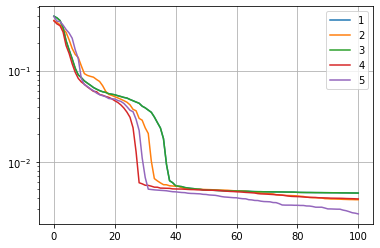

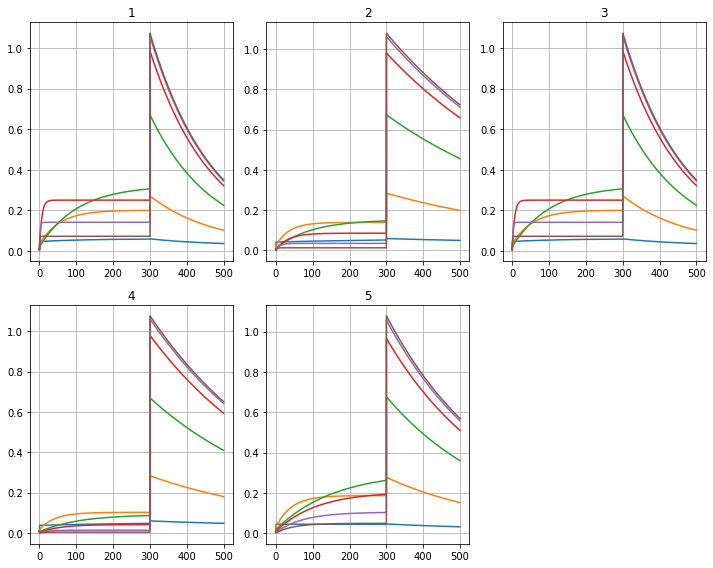

R_sq fit:  
[1] 0.9954493810714802 
[2] 0.9961711328612648 
[3] 0.9954493810714802 
[4] 0.9960934112616309 
[5] 0.9973334704746518

final_fitness:  
[1] 0.004539151562999117 
[2] 0.003819218556927018 
[3] 0.004539151562999117 
[4] 0.003896744301446274 
[5] 0.0026598099847276184


In [2]:
import pickle
import matplotlib.pyplot as plt

# Creating a class to hold the trials data
import pickle

class GA_trial:
    gen_num = 0
    loss = 0
    R_sq_ini = 0
    R_sq_fin = 0
    Parameters = 0
    final_fit_Val = 0
    time = 0
    cur_time_fit = 0
    cur_time_ini = 0
    Vcm = 0
    I_peaks_fin = 0
    I_peaks_ini = 0
    

GA1 = pickle.load(open('IKr_GA_trial_1.p', 'rb'))
GA2 = pickle.load(open('IKr_GA_trial_2.p', 'rb'))
GA3 = pickle.load(open('IKr_GA_trial_1.p', 'rb'))
GA4 = pickle.load(open('IKr_GA_trial_4.p', 'rb'))
GA5 = pickle.load(open('IKr_GA_trial_5.p', 'rb'))
plt.plot(GA1.gen_num, GA1.loss, label='1')
plt.plot(GA2.gen_num, GA2.loss, label='2')
plt.plot(GA3.gen_num, GA3.loss, label='3')
plt.plot(GA4.gen_num, GA4.loss, label='4')
plt.plot(GA5.gen_num, GA5.loss, label='5')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()
plt.figure(figsize = (10,8))
plt.subplot(2,3,1)
plt.plot(GA1.time, GA1.cur_time_fit)
plt.title('1')
plt.grid()
plt.subplot(2,3,2)
plt.plot(GA2.time, GA2.cur_time_fit)
plt.title('2')
plt.grid()
plt.subplot(2,3,3)
plt.plot(GA3.time, GA3.cur_time_fit)
plt.title('3')
plt.grid()
plt.subplot(2,3,4)
plt.plot(GA4.time, GA4.cur_time_fit)
plt.title('4')
plt.grid()
plt.subplot(2,3,5)
plt.plot(GA5.time, GA5.cur_time_fit)
plt.title('5')
plt.grid()
plt.tight_layout()
plt.show()

print('R_sq fit: ', '\n[1]', GA1.R2_sq_fin, '\n[2]', GA2.R2_sq_fin, '\n[3]', GA3.R2_sq_fin, '\n[4]', GA4.R2_sq_fin, '\n[5]', GA5.R2_sq_fin)

print('\nfinal_fitness: ', '\n[1]', GA1.final_fit_val, '\n[2]', GA2.final_fit_val, '\n[3]', GA3.final_fit_val, '\n[4]', GA4.final_fit_val, '\n[5]', GA5.final_fit_val)

In [3]:
import numpy as np

IKr_trials_r2 = np.array([GA1.R2_sq_fin, GA2.R2_sq_fin, GA3.R2_sq_fin, GA4.R2_sq_fin, GA5.R2_sq_fin])
IKr_trials_fit = np.array([GA1.final_fit_val, GA2.final_fit_val, GA3.final_fit_val, GA4.final_fit_val, GA5.final_fit_val])

mean_r2 = np.mean(IKr_trials_r2)
stdv_r2 = np.std(IKr_trials_r2)

mean_fit = np.mean(IKr_trials_fit)
stdv_fit = np.std(IKr_trials_fit)

print('mean r2: ', mean_r2)
print('stdv r2: ', stdv_r2)
print('\n')

print('mean loss: ', mean_fit)
print('stdv loss: ', stdv_fit)

mean r2:  0.9960993553481016
stdv r2:  0.0006889354991113475


mean loss:  0.0038908151938198293
stdv loss:  0.0006871994110511049


mean:  [0.0566679  0.27669967 0.68277489 0.97881861 1.05897815 1.07563399]
stdv:  [0.00338077 0.01576511 0.04524142 0.05563638 0.06317619 0.06587501]


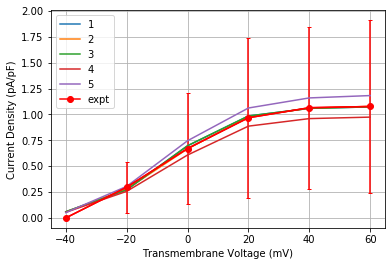

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# IkrIni, time, IKrIni_time = Ikr_func(0.035, 10, 5, 550, 22, 9, 6, 11, 9, 230, 40, 20, 74, 24)

# Ikrfit, time, IKrfit_time  = Ikr_func(6.75179737e-02, -9.23225436e+00,  1.00224281e+01,  5.62604581e+02,
#   2.20935149e+01,  2.05617335e-01, -3.41704934e-01,  1.60699851e+01,
#   3.15075992e-01,  4.90484972e+02,  3.08905343e+01,  3.91636784e+01,
#   5.09891436e+01,  2.09719665e+01)
Ikr_act = np.array(
    [0.0000, 0.296491453, 0.670409, 0.967468331, 1.064629846, 1.076653804 ])
Ikr_err = np.array([0.000, 0.246868565, 0.539902624, 0.771099748, 0.782198549, 0.832950241])

Vcm = np.arange(-40, 61, 20)

plt.plot(GA1.Vcm, GA1.I_peaks_fin, label='1')
plt.plot(GA2.Vcm, GA2.I_peaks_fin, label='2')
plt.plot(GA3.Vcm, GA3.I_peaks_fin, label='3')
plt.plot(GA4.Vcm, GA4.I_peaks_fin, label='4')
plt.plot(GA5.Vcm, GA5.I_peaks_fin, label='5')
plt.plot(Vcm, Ikr_act, 'r-o', label='expt')
plt.errorbar(Vcm, Ikr_act, yerr=Ikr_err, capsize=2, color = 'red')
plt.xlabel('Transmembrane Voltage (mV)')
plt.ylabel('Current Density (pA/pF)')
plt.grid()
plt.legend()

IKr_GA_IV = np.zeros((5,len(GA1.I_peaks_fin)))
IKr_GA_IV[0,:] = GA1.I_peaks_fin
IKr_GA_IV[1,:] = GA2.I_peaks_fin
IKr_GA_IV[2,:] = GA3.I_peaks_fin
IKr_GA_IV[3,:] = GA4.I_peaks_fin
IKr_GA_IV[4,:] = GA5.I_peaks_fin


IKr_mean = np.mean(IKr_GA_IV, axis=0)
IKr_stdv = np.std(IKr_GA_IV, axis=0)
#print(If_GA_IV)
print('mean: ',IKr_mean)
print('stdv: ',IKr_stdv)

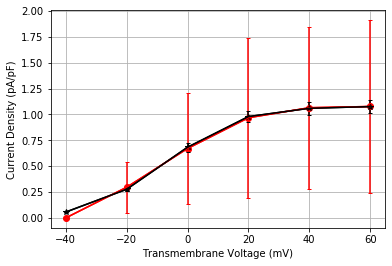

In [6]:
# plt.figure(figsize=(10,8))
plt.plot(Vcm, Ikr_act, 'r-o', label='expt')
plt.errorbar(Vcm, Ikr_act, yerr=Ikr_err, capsize=2, color = 'red')
plt.plot(Vcm, IKr_mean, 'k-*', label = 'Model(mean)')
plt.errorbar(Vcm, IKr_mean, yerr=IKr_stdv, capsize=2, color = 'black')
plt.grid()
plt.xlabel('Transmembrane Voltage (mV)')
plt.ylabel('Current Density (pA/pF)')
plt.show()

In [12]:
loss_ini = np.array([GA1.loss[0], GA2.loss[0], GA3.loss[0], GA4.loss[0], GA5.loss[0]])
loss_ini_mean = np.mean(loss_ini)
loss_ini_stdv = np.std(loss_ini)

print('initial losses: ', loss_ini)
print('mean initial loss: ', loss_ini_mean)
print('std initial loss: ', loss_ini_stdv)

initial losses:  [0.39650392 0.35554041 0.39650392 0.3531958  0.39237665]
mean initial loss:  0.3788241377983743
std initial loss:  0.020038779209523527


In [13]:
loss_fin = np.array([GA1.loss[-1], GA2.loss[-1], GA3.loss[-1], GA4.loss[-1], GA5.loss[-1]])
loss_fin_mean = np.mean(loss_fin)
loss_fin_stdv = np.std(loss_fin)

print('initial losses: ', loss_fin)
print('mean initial loss: ', loss_fin_mean)
print('std initial loss: ', loss_fin_stdv)

initial losses:  [0.00454087 0.00383984 0.00454087 0.00391454 0.00268129]
mean initial loss:  0.0039034779897882815
std initial loss:  0.0006797721671106038
